In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import layers
# Load the data
df = pd.read_csv('../data/loan_data.csv')
df.head()


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


/var/folders/_w/1v5jxkz56qxcjphx0msmcxr00000gn/T/ipykernel_62634/1073336655.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_rates = df.groupby('fico_band')['not.fully.paid'].mean().dropna()


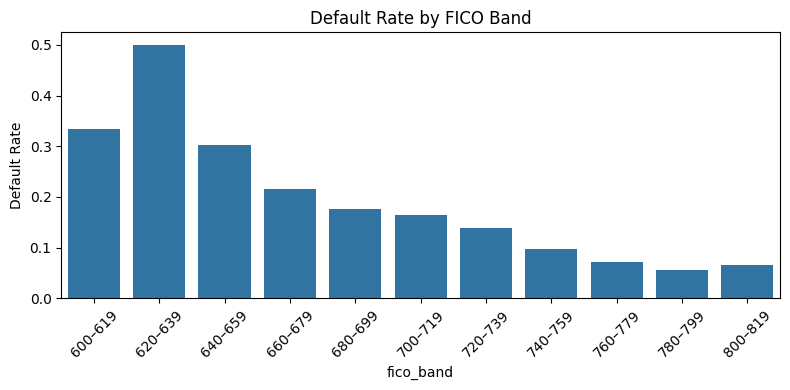

In [2]:
# Create 20-point FICO bands
bins   = list(range(600, 821, 20))
labels = [f"{b}–{b+19}" for b in bins[:-1]]
df['fico_band'] = pd.cut(df['fico'], bins=bins, labels=labels, right=False)

# Compute default rate per band
band_rates = df.groupby('fico_band')['not.fully.paid'].mean().dropna()

# Plot
plt.figure(figsize=(8,4))
sns.barplot(x=band_rates.index, y=band_rates.values)
plt.xticks(rotation=45)
plt.ylabel("Default Rate")
plt.title("Default Rate by FICO Band")
plt.tight_layout()
plt.show()



In [3]:
# Feature and target
X = df[['fico']].astype(float)
y = df['not.fully.paid']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Scale FICO
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

# Compute class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.array([0,1]), y=y_train
)
class_weights = {0: weights[0], 1: weights[1]}

print("Train class balance:", np.bincount(y_train)/len(y_train))
print("Class weights:", class_weights)


Train class balance: [0.83998956 0.16001044]
Class weights: {0: 0.5952454940957116, 1: 3.124796084828711}


In [4]:
model_fico = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])
model_fico.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name='auc'),
             keras.metrics.Recall(name='sensitivity')]
)
model_fico.summary()


2025-06-07 16:41:19.173604: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-06-07 16:41:19.173670: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-07 16:41:19.173683: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-07 16:41:19.173711: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-07 16:41:19.173733: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49 (196.00 B)

 Trainable params: 49 (196.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train
history = model_fico.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    class_weight=class_weights,
    verbose=1
)

# Final evaluation
loss_f, auc_f, sens_f = model_fico.evaluate(X_test, y_test, verbose=0)
print(f"FICO-only Test loss={loss_f:.4f}, AUC={auc_f:.4f}, Sensitivity={sens_f:.4f}")


Epoch 1/20


2025-06-07 16:41:25.374892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - auc: 0.3864 - loss: 0.7448 - sensitivity: 0.3244 - val_auc: 0.3898 - val_loss: 0.7074 - val_sensitivity: 0.3872
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.4188 - loss: 0.7091 - sensitivity: 0.5587 - val_auc: 0.6090 - val_loss: 0.6994 - val_sensitivity: 0.7872
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6170 - loss: 0.6754 - sensitivity: 0.7503 - val_auc: 0.6096 - val_loss: 0.6935 - val_sensitivity: 0.7021
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.5914 - loss: 0.6859 - sensitivity: 0.6945 - val_auc: 0.6096 - val_loss: 0.6902 - val_sensitivity: 0.6681
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6170 - loss: 0.6683 - sensitivity: 0.6757 - val_auc: 0.6096 - val_loss: 0.6863 - val_sensitivity: 0.6681
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6099 - loss: 0.6741 - sensitivity: 0.6534 - val_auc: 0.6096 - val_loss: 0.6830 - val_sensitivity: 0.6681
Epoch 7/20
24/24 ━━━━

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


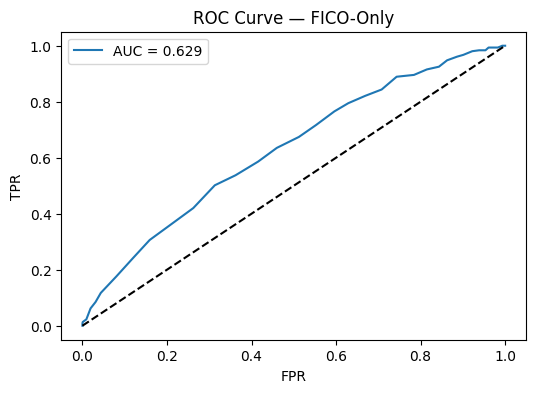

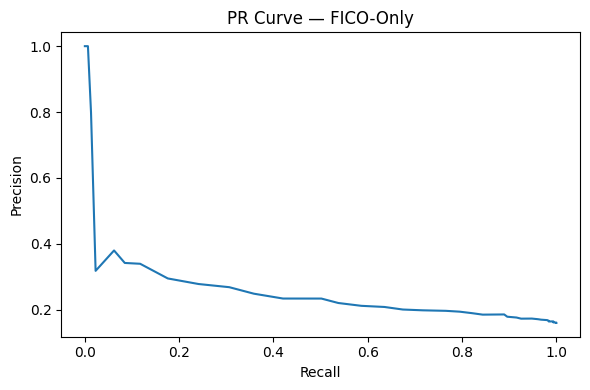

In [6]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

y_prob = model_fico.predict(X_test).reshape(-1)

# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curve — FICO-Only")
plt.legend(); plt.show()

# PR
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR Curve — FICO-Only")
plt.tight_layout(); plt.show()
